# Step 1 - set up equilibrium age structures

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
M = 0.3 #Natural mortality rate in units yr^{-1}
m = 10
age = np.arange(0, m+2, 1)


Set up equilibrium equations

In [3]:
N0 = np.zeros(m+1)
age_range = np.arange(0, m+1, 1)

#solve the eqts A1, A2 for C_{1949, a} = 0

N0[0] = 1                     #In equilibrium, N{1949, 0} = R = 1
for i in range(1, 11):
    N0[i] = N0[i-1]*np.exp(-M) #N{1949, a} = N{1949, a-1}e^{-M} for a = 1 to 9

     
N0[10] = N0[10]/(1 - np.exp(-M)) #N{1949, 10} = N{1949, 10}/(1 = e^{-M}) 

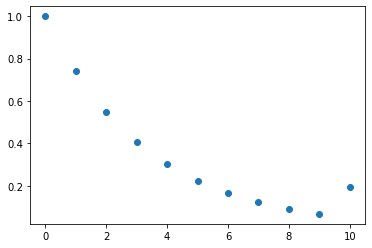

In [4]:
plt.scatter(age_range, N0)

# Step 2 - Solve for R_{0} and Scale up N0

In [5]:
K = 773000 #Eq. Spawning Biomass (B_{sp} in 1949)

In [6]:
f = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1 ] #knife edge function

We have to solve for the weights at age of the fish:

In [7]:
l_infty = 54.56 #asymptotic length
kappa = 0.183 #growth rate in year^{-1}
sigma = 0.0078
mu = 3.011

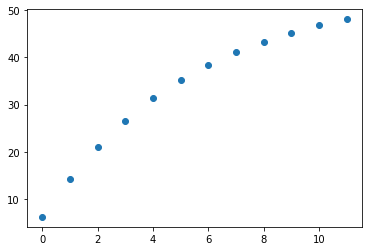

In [8]:
l = np.zeros(m+2)
for i in range(len(l)):
    l[i]= l_infty*(1 - np.exp(-kappa*(i + 0.654)))
    
plt.scatter(age, l)

Now for the weights

In [9]:
w = np.zeros(m+2)

for i in range(len(w)):
    w[i] = sigma*(l[i]**mu)

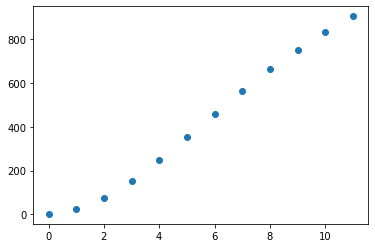

In [10]:
plt.scatter(age, w)

Now for the big sum in equation A.16

In [11]:
big_sum = 0
for a in range(1,m+1):
    M_sum = 0    
    if a==m:
        M_sum = 0
        for a_prime in range(0,a):
            M_sum = M_sum + M
            # print(a_prime)
        big_sum = big_sum + f[a]*w[a]*np.exp(-M_sum)/(1-np.exp(-M))
    elif a<m:
        for a_prime in range(0,a):
            M_sum = M_sum + M
        big_sum = big_sum + f[a]*w[a]*np.exp(-M_sum)



In [14]:
print(big_sum)

631.487275480067


So now we can solve for R_{0}:

In [15]:
R0 = K/big_sum

In [16]:
print(R0)

1224.0943404795494


We now scale up the equilibrium values from step 1 by R0!

In [17]:
N0 = R0*N0
print(N0)

[1224.09434048  906.83139126  671.79721773  497.6796195   368.69013019
  273.13236623  202.34143356  149.89822078  111.0473332    82.26588779
  235.1402509 ]


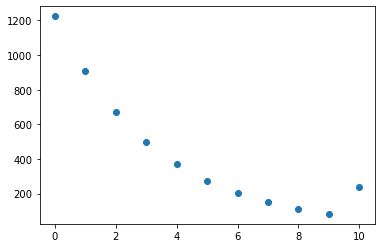

In [18]:
plt.scatter(age_range, N0)

# Step 3- Calculate Alpha, Beta from A15, A16

In [19]:
h = 0.75 #Steepness of stock-recruit relationship

In [20]:
alpha = (4*h*R0)/(5*h -1)  #From eqtn A.15 
print(alpha)

1335.3756441595085


In [21]:
beta = (K*(1 - h))/(5*h-1) #From eqtn A.16
print(beta)

70272.72727272728


# Step 4 - Caluclate B^{sp} from eqtn A.11

In [50]:
def B_y(N):                   #Calculates spawning biomass in a year given a vector for number at age      
    By = 0
    for i in range(m+1):
        By += f[i]*w[i]*N[i]
    return By

In [51]:
print(B_y(N0))

773000.0000000002


# Step 5- Calculate Ry from eqn A12

In [24]:
def R_y(B_y, res = 0):                              #Calculates recruitment for some spawning biomass in year y
    Ry = ((alpha*B_y)/(beta + B_y))*np.exp(res)
    
    return Ry

In [25]:
R_y_array = np.zeros(2019 - 1949)

In [26]:
R_y_array[0] = R0

In [27]:
print(R_y(B_y(N0)))  #this looks correct because it equals R0

1224.0943404795494


# Step 6 - Calculate Exploitable Biomass

In [28]:
S_d = [ [0.031846994, 0.324722195, 1.010811598, 1.613619595, 1.750432852, 1.539871974, 1.222136785, 0.930213297, 0.700873124, 0.531055815,
       0.408345],[0.256693509, 1.130899563, 1.646709242, 1.385048839, 0.887258232, 0.509085997, 0.286245059, 0.165246792,0.100045816,
                  0.063973673,0.043205903]] #S_d[0, :] is Old Gear, S_d[1,: ] is New Gear (from 2004 onward)

S_p = [[0, 0,0.3, 1, 0.5, 0.5, 0.25, 0, 0, 0, 0], [0.14, 0.5, 0.4, 0.5, 0.25, 0.25, 0.13, 0, 0, 0, 0], [0.28, 1, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]]
#S_p[0, :] is 1949-1962, S_p[1,:] is 1963-1967, S_p[2,:] is 1968+

S_m = [0.000448071, 0.082052316, 0.912313145, 2.084072816, 2.085245924, 1.409150807, 0.81268578, 0.451574377, 0.256651557, 0.153260073, 0.097077504]


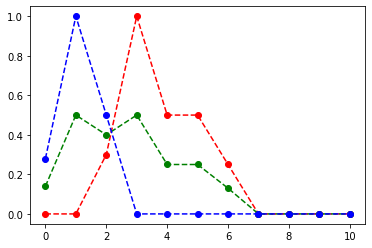

In [29]:
plt.plot(age_range, S_p[0], 'ro--')
plt.plot(age_range, S_p[1], 'go--')
plt.plot(age_range, S_p[2], 'bo--')

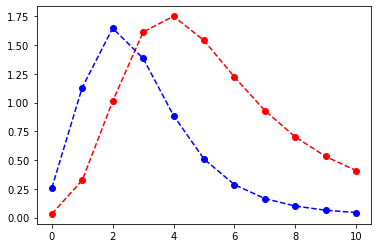

In [30]:
plt.plot(age_range, S_d[0], 'ro--')
plt.plot(age_range, S_d[1], 'bo--')

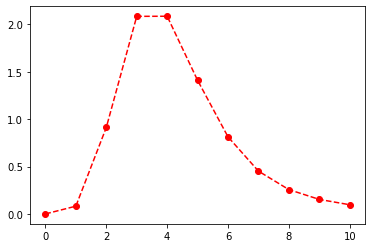

In [31]:
plt.plot(age_range, S_m, 'ro--')

In [32]:
def B_f(fleet, year, N_y):      #calculates exploitable biomass in a year given a vector of number at age for that year and the type of fleet
    y0 = 1949
    
    if fleet == 'd':
        if (year >= 1949) and (year < 2004):
            sel = S_d[0]
            ans = 0
            for i in range(m+1):
                midweight = (w[i] + w[i+1])/2
                ans += midweight*sel[i]*N_y[i]*np.exp(-M/2)
        elif (year >= 2004):
            sel = S_d[1]
            ans = 0
            for i in range(m+1):
                midweight = (w[i] + w[i+1])/2
                ans += midweight*sel[i]*N_y[i]*np.exp(-M/2)

    elif fleet == 'p':
        if (year <= 1962) and (year >= 1949):
            sel = S_p[0]
            ans = 0
            for i in range(m+1):
                midweight = (w[i] + w[i+1])/2
                ans += midweight*sel[i]*N_y[i]*np.exp(-M/2)
                    
        elif (year >= 1963) and (year <= 1967):
            sel = S_p[1]
            ans = 0
            for i in range(m+1):
                midweight = (w[i] + w[i+1])/2
                ans += midweight*sel[i]*N_y[i]*np.exp(-M/2)
        elif (year >= 1968):
            sel = S_p[2]
            ans = 0
            for i in range(m+1):
                midweight = (w[i] + w[i+1])/2
                ans += midweight*sel[i]*N_y[i]*np.exp(-M/2)
    
    elif fleet == 'm':
        sel = S_m
        ans = 0
        for i in range(m+1):
            midweight = (w[i] + w[i+1])/2
            ans += midweight*sel[i]*N_y[i]*np.exp(-M/2)
    
    return ans

In [33]:
print(B_f('d', 1949, N0)) #this agrees with what Grant got

863388.5808164524


# Step 7 - Solve for F^{f} from equation A.9

In [34]:
C_p = [3360,49900,98900,102600,85200,118100,78800,45800,84600,56400,17700,62900,38900,66700,23300,24400,55000, 26300,8800,1400,26800,7900,2200,1300,1600,2500,1600,400,1900,3600,4300,400,6100,1100,2100,2800,700,500,2834,6403,25872,7645,582,2057,11651,8207,1986,18920,12654,26680,2057,4503,915,8148,1012,2048,5627,4824,1903,2280,2087,4385,10990,2199,596,2760,2040,1588,1466,967,1044]

C_m = [1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,1.00E-05,15769.8,2160.77,15408,19198,11098.47226,25306,27153,28998,18057,25028,23772,29019,30791,29048.46288,22579,28417,10053.03118,7976,11613,17545,22775,15353]

C_d = [1.00E-05,445,1105,1226,1456,2550,1926,1334,959,2073,2075,3712,3627,3079,1401,9522,7017,7596,6189,9116,12252,17872,33329,20560,33900,38391,55459,50981,116400,37290,53584.5,39187.5,41215,32176,38332,37969,27278,31378,38571,41482,58205.5,56721.29955,39759.1435,37207.52597,35998,20029.5,10790,31846,34670.5,36278.79654,21579.72715,9228.977402,8813.736107,4863.110874,3562.168326,4933.367342,5280.164393,4132.99023,4811.69777,4449.294927,4128.812833,5595.850227,5228.259958,4941.442171,2695.003339,3087.009933,4747.105611,5230.373962,5703.439322,4625.879504,3145]


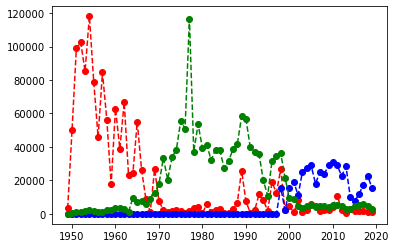

In [35]:
time = np.arange(1949, 2020, 1)

plt.plot(time, C_p, 'ro--')
plt.plot(time, C_m, 'bo--')
plt.plot(time, C_d, 'go--')

In [36]:
def F_f(fleet, year, N_y):   #Proportion of exploitable biomass being caught in a year
    y_index = year - 1949
    
    if fleet == 'p':
        catch = C_p
    elif fleet == 'm':
        catch = C_m
    elif fleet == 'd':
        catch = C_d
        
    F_f = catch[y_index]/B_f(fleet, year, N_y)
    
    return F_f
    

In [37]:
print(F_f('d', 1949, N0))

1.1582270396191282e-11


In [38]:
1.00E-05/B_f('d', 1949, N0)

1.1582270396191282e-11

# Step 8 - Calculate C^{f,y, a} from equation A.10 

In [39]:
def C_fya(fleet, year, N_y):
    C_fya = np.zeros(m+1)
    
    if fleet == 'd':
        if year < 2004:
            sel = S_d[0]
        elif year >= 2004:
            sel = S_d[1]
    elif fleet == 'm':
        sel = S_m
    elif fleet == 'p':
        if year <= 1962:
            sel = S_p[0]
        elif (year >= 1963) and (year <= 1967):
            sel = S_p[1]
        elif (year >= 1968):
            sel = S_p[2]
    
    for i in range(m+1):
        C_fya[i] = sel[i]*F_f(fleet, year, N_y)*N_y[i]*np.exp(-M/2)
        
    return C_fya

In [40]:
print(C_fya('p', 1949, N0))

[0.         0.         2.61166847 6.44923864 2.38885675 1.7697086
 0.65551619 0.         0.         0.         0.        ]


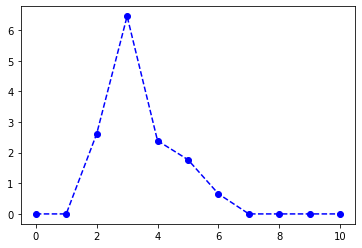

In [41]:
#plt.plot(age_range, C_fya('d', 2000, N0)/7)
plt.plot(age_range, C_fya('p', 1949, N0), 'bo--')

# Step 9 - Calculate C_{y,a} from equation A.4

In [42]:
def C_ya(year, N_y):
    C_ya = C_fya('p', year, N_y) + C_fya('d', year, N_y) + C_fya('m', year, N_y)
    
    return C_ya

In [43]:
print(C_ya(1949, N0)[3])

6.4492386553168615


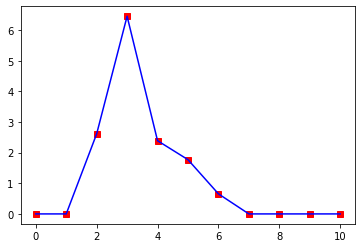

In [44]:
plt.plot(age_range, C_fya('p', 1949, N0) + C_fya('d', 1949, N0) + C_fya('m', 1949, N0), 'rs')
plt.plot(age_range, C_ya(1949, N0), 'b')

# Step 10 - Update Equations

In [45]:
N_y_a = []
for i in range(1949, 2020):
    N_y_a.append(np.zeros(m+1))
    
N_y_a[0] = N0    #I set up an array of arrays with the first element being the initial number at age we calculated


In [46]:
for year in range(1949, 2019):   #These SHOULD BE the update equations
    y_index = year - 1949
    for a in range(0, m-2):
        N_y_a[y_index+1][a+1] = (N_y_a[y_index][a]*np.exp(-M/2) - C_ya(year, N_y_a[y_index])[a])*np.exp(-M/2)
    N_y_a[y_index + 1][0] = R_y(B_y(N_y_a[y_index]))
    N_y_a[y_index + 1][m] = (N_y_a[y_index][m]*np.exp(-M/2) - C_ya(year, N_y_a[y_index])[a])*np.exp(-M/2) + (N_y_a[y_index][m-1]*np.exp(-M/2) - C_ya(year, N_y_a[y_index])[a])*np.exp(-M/2)

    

In [47]:
B_sp_overtime = np.zeros(2020-1949)

for year in range(1949, 2020):
    y_index = year - 1949
    B_sp_overtime[y_index] = B_y(N_y_a[y_index])  #array of spawning biomasses

In [48]:
time = np.arange(1949, 2020, 1)
print(len(time))

71


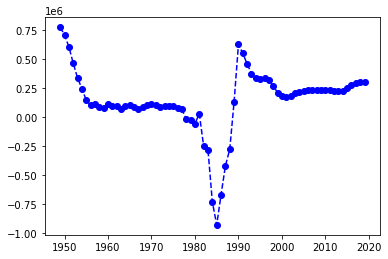

In [49]:
plt.plot(time, B_sp_overtime, 'bo--') #plot comes out very wrong